In [1]:
import json 

def load_json_data(path):
    with open(path) as f:
        json_data = json.load(f)
    return json_data['data']

json_datas = load_json_data('data/train-v2.0.json')

In [2]:
from transformers import AutoTokenizer, BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")

In [3]:
def find_target_sublist(my_list, target_sublist):
    target_length = len(target_sublist)
    for i in range(len(my_list)):
        if my_list[i:i + target_length] == target_sublist:
            return i, i + target_length

In [4]:
import torch
from torch.nn.utils.rnn import pad_sequence

input_data = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[], 'start_positions':[], 'end_positions':[]}
for json_data in json_datas:
    
    paragraphs = json_data['paragraphs'][0]
    
    # 取得內文
    context = paragraphs['context']
    
    # 取得QA資料
    qas = paragraphs['qas']
    for qa in qas:
        try:
            if not qa['is_impossible']: # 不使用不可能的QA解答
                # 取得問題
                question = qa['question']   
                
                # 取得答案
                answers = qa['answers'][0]['text']
                answers_ids = tokenizer(answers).input_ids[1:-1]
                
                # 轉換成數字
                inputs = tokenizer(context, question, return_tensors="pt")
                inputs_ids = list(inputs.input_ids[0])
                
                #更新答案位子
                start_positions, end_positions = find_target_sublist(inputs_ids, answers_ids)
                start_positions, end_positions = torch.tensor([start_positions]), torch.tensor([end_positions])

                # 存入字典中
                input_data['input_ids'].append(inputs.input_ids[0])
                input_data['token_type_ids'].append(inputs.token_type_ids[0])
                input_data['attention_mask'].append(inputs.attention_mask[0])
                input_data['start_positions'].append(start_positions)
                input_data['end_positions'].append(end_positions)
        except:
            # 部分斷詞錯誤的結果
            if not qa['is_impossible']:
                print('=' * 40)
                print('內容:', context)
                print('答案:', answers)

input_data = {k:pad_sequence(v, padding_value=0, batch_first=True) for k, v in input_data.items()}

內容: The iPod is a line of portable media players and multi-purpose pocket computers designed and marketed by Apple Inc. The first line was released on October 23, 2001, about 8½ months after iTunes (Macintosh version) was released. The most recent iPod redesigns were announced on July 15, 2015. There are three current versions of the iPod: the ultra-compact iPod Shuffle, the compact iPod Nano and the touchscreen iPod Touch.
答案: 3
內容: Spectre (2015) is the twenty-fourth James Bond film produced by Eon Productions. It features Daniel Craig in his fourth performance as James Bond, and Christoph Waltz as Ernst Stavro Blofeld, with the film marking the character's re-introduction into the series. It was directed by Sam Mendes as his second James Bond film following Skyfall, and was written by John Logan, Neal Purvis, Robert Wade and Jez Butterworth. It is distributed by Metro-Goldwyn-Mayer and Columbia Pictures. With a budget around $245 million, it is the most expensive Bond film and one o

In [5]:
from torch.utils.data import Dataset, DataLoader
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return {k:v[index] for k, v in self.data.items()}     
        
    def __len__(self):
        return len(self.data['input_ids'])

dataset = QADataset(input_data)

train_simple = int(len(input_data['input_ids']) * 0.8)
valid_simple = len(input_data['input_ids']) - train_simple
trainset, validset = torch.utils.data.random_split(dataset, [train_simple, valid_simple])

train_loader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True)

In [6]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt 

def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() 
    for input_datas in train_pbar: 
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad() 
        
        outputs = model(**input_datas) 
        
        loss = outputs.loss

        loss.backward()
        optimizer.step() 
        
        train_pbar.set_description(f'Train Epoch {epoch}') 
        train_pbar.set_postfix({'loss':f'{loss:.3f}'})

        train_loss += loss.item()  
    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
            
            outputs = model(**input_datas)
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            valid_loss += loss.item()

    return valid_loss/len(valid_loader)


def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()


Valid Epoch 0: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.23it/s, loss=1.252]


Saving Model With Loss 1.30192
Train Loss: 2.21503| Valid Loss: 1.30192| Best Loss: 1.30192



Valid Epoch 1: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.08it/s, loss=1.155]


Saving Model With Loss 1.28788
Train Loss: 0.90966| Valid Loss: 1.28788| Best Loss: 1.28788



Valid Epoch 2: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.11it/s, loss=1.684]


Train Loss: 0.52878| Valid Loss: 1.70067| Best Loss: 1.28788



Valid Epoch 3: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.15it/s, loss=2.443]


Train Loss: 0.33954| Valid Loss: 1.79230| Best Loss: 1.28788



Valid Epoch 4: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.19it/s, loss=2.446]


Train Loss: 0.25185| Valid Loss: 2.12619| Best Loss: 1.28788



Valid Epoch 5: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.18it/s, loss=1.809]


Train Loss: 0.18896| Valid Loss: 2.08500| Best Loss: 1.28788



Valid Epoch 6: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.16it/s, loss=2.268]


Train Loss: 0.18119| Valid Loss: 2.06045| Best Loss: 1.28788



Valid Epoch 7: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.12it/s, loss=1.669]


Train Loss: 0.17172| Valid Loss: 2.14880| Best Loss: 1.28788



Valid Epoch 8: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.16it/s, loss=1.103]


Train Loss: 0.16243| Valid Loss: 2.38144| Best Loss: 1.28788



Valid Epoch 9: 100%|███████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.17it/s, loss=2.332]


Train Loss: 0.17496| Valid Loss: 2.28696| Best Loss: 1.28788



Valid Epoch 10: 100%|██████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.17it/s, loss=2.865]


Train Loss: 0.15048| Valid Loss: 2.00934| Best Loss: 1.28788



Valid Epoch 11: 100%|██████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.17it/s, loss=2.948]


------------------------------------
|Model can't improve, stop training|
------------------------------------


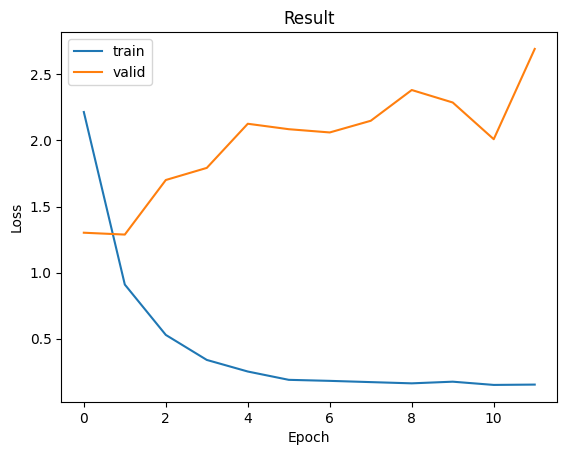

In [8]:
epochs = 100                             # 訓練次數
early_stopping = 10                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                 # 最佳的Loss
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f}' , end='| ')
    print(f'Valid Loss: {valid_loss:.5f}' , end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')


if show_loss:
    show_training_loss(loss_record)

In [9]:
model = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2").to(device)
model.load_state_dict(torch.load(model_path))

preds = next(iter(valid_loader))
for k in preds:
    preds[k] = preds[k].to(device)
output = model(**preds)

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
IDX = 31

start = preds['start_positions'][IDX]
end = preds['end_positions'][IDX]

pred_start = output.start_logits.argmax(dim = 1)[IDX]
pred_end = output.end_logits.argmax(dim = 1)[IDX]

input_ids = preds['input_ids'][IDX] 
input_ids = input_ids[input_ids !=0]

context, question = tokenizer.decode(input_ids[1:-1]).split('[SEP]')                                                               
pred_answer = tokenizer.decode(input_ids[pred_start:pred_end])
answer = tokenizer.decode(input_ids[start:end])

print('文章內容:', context)
print('問題:', question.strip())
print('預測解答:', pred_answer)
print('實際解答:', answer)

文章內容: Relations between Grand Lodges are determined by the concept of Recognition. Each Grand Lodge maintains a list of other Grand Lodges that it recognises. When two Grand Lodges recognise and are in Masonic communication with each other, they are said to be in amity, and the brethren of each may visit each other's Lodges and interact Masonically. When two Grand Lodges are not in amity, inter - visitation is not allowed. There are many reasons why one Grand Lodge will withhold or withdraw recognition from another, but the two most common are Exclusive Jurisdiction and Regularity. 
問題: What concept is used to determine relations between Grand Lodges?
預測解答: Recognition
實際解答: Recognition
